# Janus plots
This notebooks processes the raw measurement data of Janus experiments and generates the figures in the paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Set plot style

In [3]:
sns.set_style()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('figure', figsize=(5.5,4))
plt.rc('text.latex', preamble=r'\usepackage{mathptmx}')

data_dir = '../data/'
fig_dir = '../figures/'

COLOR_PALETTE = ['#88CCEE','#CC6677','#DDCC77','#117733', '#332288','#AA4499','#44AA99', '#999933']
PLT_MARKER = [6, 6, 7, 7]
WIDE_PLOTS = True

## Read and process raw data

In [4]:
# Read TEE-Janus data
def read_tee():
    iris_tee = pd.read_csv(f'{data_dir}iris_tee.csv')
    iris_tee = iris_tee.melt(value_name='rs_comp', var_name='users')
    iris_tee['bio'] = 'iris'

    finger_tee = pd.read_csv(f'{data_dir}finger_tee.csv')
    finger_tee = finger_tee.melt(value_name='rs_comp', var_name='users')
    finger_tee['bio'] = 'finger'


    tee = pd.concat([iris_tee, finger_tee])
    tee['approach'] = 'tee'
    tee['rs_comp'] /= 1000
    tee['rs_comp'] = tee['rs_comp'].astype(int)
    tee['users'] = tee['users'].astype(int)

    tee = tee.query('users < 4000')

    return tee

In [5]:
# Read SMC-Janus data
def read_smc():
    iris_smc = pd.read_csv(f'{data_dir}iris_smc.csv')
    iris_smc['approach'] = 'smc'
    iris_smc['bio'] = 'iris'

    finger_smc = pd.read_csv(f'{data_dir}finger_smc.csv')
    finger_smc['approach'] = 'smc'
    finger_smc['bio'] = 'finger'

    iris_smc['transfer'] = iris_smc['rs_transfer']+iris_smc['bp_transfer']
    finger_smc['transfer'] = finger_smc['rs_transfer']+finger_smc['bp_transfer']

    return pd.concat([iris_smc, finger_smc])

The cost of running Hyb-Janus include the costs of running both the distance computation component using SHE and the threshold comparison component using SMC.

In [6]:
# Read Hyb-Janus data
def read_he():
    iris_he = pd.read_csv(f'{data_dir}iris_hyb_dist.csv')
    iris_he['approach'] = 'he'
    iris_he['bio'] = 'iris'

    iris_he_f2 = iris_he.copy()
    iris_he['fuse'] = 1
    iris_he_f2['fuse'] = 2
    iris_he_f2['users'] /= 2
    iris_he = pd.concat([iris_he, iris_he_f2])
    

    finger_he = pd.read_csv(f'{data_dir}finger_hyb_dist.csv')
    finger_he['approach'] = 'he'
    finger_he['bio'] = 'finger'

    finger_he_f4 = finger_he.copy()
    finger_he['fuse'] = 1
    finger_he_f4['fuse'] = 4
    finger_he_f4['users'] /= 4
    finger_he = pd.concat([finger_he, finger_he_f4])

    iris_thresh = pd.read_csv(f'{data_dir}iris_hyb_thresh.csv')
    finger_thresh = pd.read_csv(f'{data_dir}finger_hyb_thresh.csv')

    iris_thresh['transfer'] = iris_thresh['rs_transfer']+iris_thresh['bp_transfer']
    finger_thresh['transfer'] = finger_thresh['rs_transfer']+finger_thresh['bp_transfer']
    iris_thresh = iris_thresh.groupby(['users', 'fuse'], as_index=False).mean()
    finger_thresh = finger_thresh.groupby(['users', 'fuse'], as_index=False).mean()

    iris = pd.merge(iris_he,iris_thresh, how='left', on=['users', 'fuse'], suffixes=('_he', '_smc'))
    finger = pd.merge(finger_he,finger_thresh, how='left', on=['users', 'fuse'], suffixes=('_he', '_smc'))


    iris['transfer'] = iris['transfer_he']+iris['transfer_smc']
    iris['bp_comp'] = iris['bp_comp_he']+iris['bp_comp_smc']
    iris['rs_comp'] = iris['rs_comp_he']+iris['rs_comp_smc']
    finger['transfer'] = finger['transfer_he']+finger['transfer_smc']
    finger['bp_comp'] = finger['bp_comp_he']+finger['bp_comp_smc']
    finger['rs_comp'] = finger['rs_comp_he']+finger['rs_comp_smc']
    
    return pd.concat([iris, finger])

### Load data in memory
Read raw measurement data and keep it in the memory

In [7]:
# Read all janus data
def read_janus():
    tee = read_tee()
    smc = read_smc()
    he = read_he()
    # We are not plotting TEE cost as they are orders of magnitude smaller than the rest
    # df =  pd.concat([tee, smc, he])
    df =  pd.concat([smc, he])

    df = df.fillna(0)
    return df

df = read_janus()
df['transfer'] /= (1024*1024) #Convert to MB
df['rs_comp'] /= 1000
df['bp_comp'] /= 1000

df = df[['users', 'approach', 'bio', 'rs_comp', 'bp_comp', 'transfer', 'fuse', 'template_size',]]
full_data = df

## Plot evaluation

In [8]:
def prepare_plot_axis(ax:plt.Axes):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim((110, 9530)) # fix the large empty space in plots 
    ax.set_xlabel('Number of registered users')

    major_ticks = [128, 512, 2048, 8192]
    minor_ticks = [2*x for x in major_ticks[:-1]]
    ax.set_xticks(major_ticks, major_ticks)
    ax.xaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax.xaxis.set_minor_formatter(plt.NullFormatter())

In [9]:
yaxis_labels = {'rs_comp':'RS\'s computation (sec)', 'bp_comp':'BP\'s computation (sec)', 'transfer': 'Communication (MB)'}

def plot_evaluation(axes, df, config, approaches=['he']):
    for j, target in enumerate(['rs_comp', 'bp_comp', 'transfer']):
        ax = axes[j]
        ax.set_ylabel(yaxis_labels[target])
        prepare_plot_axis(ax)
        for ap in approaches:
            for (f, ts) in config.keys():
                    bio_type = 'iris' if ts > 1000 else 'finger'
                    l_data = df.query(f"approach=='{ap}' & fuse=={f} & template_size=={ts}")
                    l_data = l_data[['users', target]].groupby('users').agg(['mean', 'sem']).reset_index()
                    x , y, yerr = l_data["users"], l_data[(target, 'mean')], l_data[(target, 'sem')]
                    label = f"$f={f}$, {bio_type}$_{{{ts}}}$"
                    ax.errorbar(x, y, yerr,  
                                linewidth = 2,
                                markersize = 7.5,
                                label=label,
                                **config[(f, ts)]
                        )
    axes[0].legend(
        bbox_to_anchor=(0.1, 0.88, 0.8, 0), 
        loc='lower left',
        ncol=4, 
        mode="expand", 
        borderaxespad=0., 
        bbox_transform=fig.transFigure,
    )
    plt.tight_layout()
        

## Hyb-janus performance
Plot the single-core membership performance of Hyb-Janus with $f$ iris or fingerprint samples. This plot corresponds to Fig 5 in the paper.

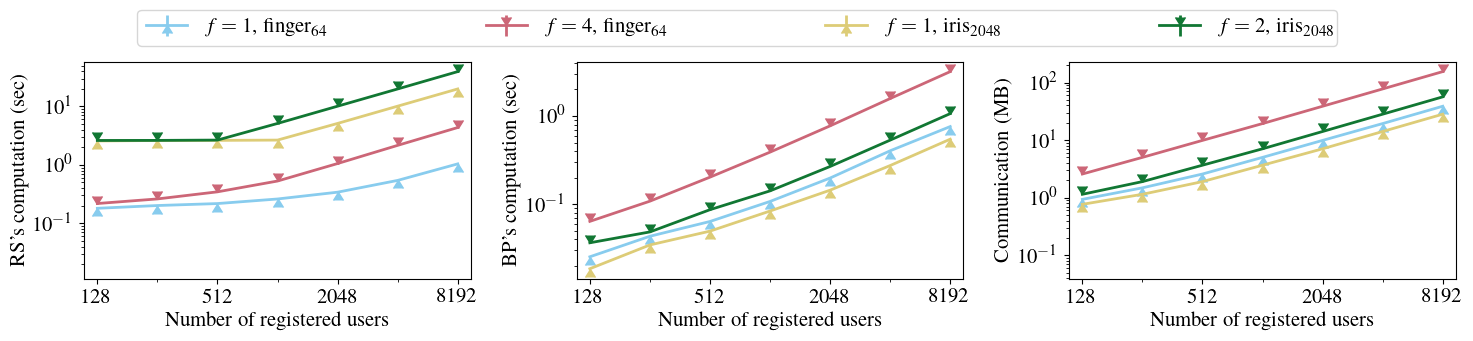

In [10]:
config = {
    (1, 64) : {
        'color': COLOR_PALETTE[0],
        'marker' :  6,
    },
    (4, 64) : {
        'color': COLOR_PALETTE[1],
        'marker' :  7,
    },
    (1, 2048) : {
        'color': COLOR_PALETTE[2],
        'marker' : 6,
    },
    (2, 2048) : {
        'color': COLOR_PALETTE[3],
        'marker' :  7,
    },
}

df = full_data.query('users>64 & users <= 8192')
fig, axes = plt.subplots(ncols=3, figsize=(15, 3.5))
plot_evaluation(axes, df, config)

plt.savefig(fig_dir+"she_eval.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show() 

# Appendix graphs

## Hyb-janus: impact of template size on performance
Plot the single-core membership performance of Hyb-Janus with $f$ iris or fingerprint samples of varied
sizes. Corresponds to Fig 8 in the paper.

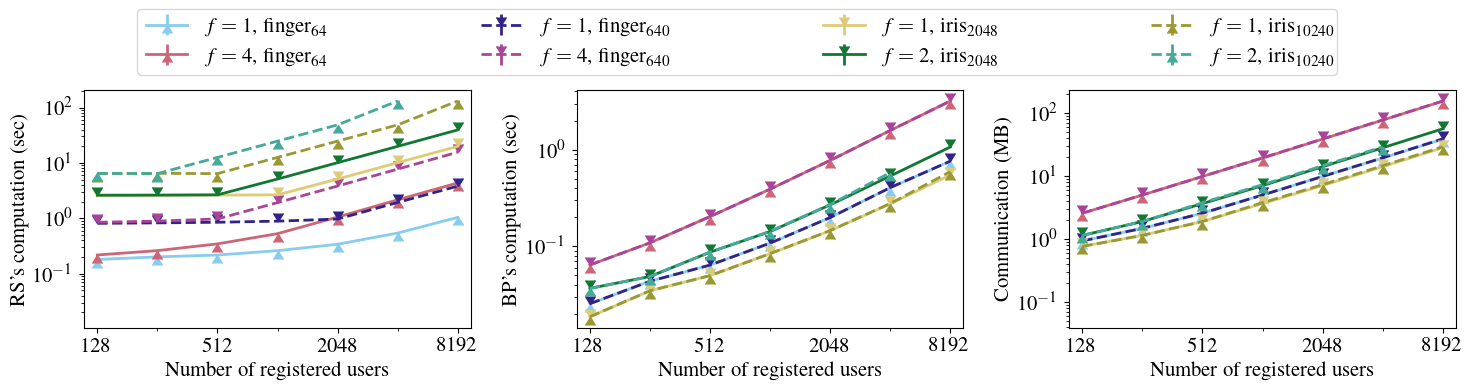

In [11]:
config = {
    (1, 64) : {
        'color': COLOR_PALETTE[0],
        'marker' :  6,
        'linestyle' : 'solid'
    },
    (4, 64) : {
        'color': COLOR_PALETTE[1],
        'marker' :  6,
        'linestyle' : 'solid'
    },
    (1, 640) : {
        'color': COLOR_PALETTE[4],
        'marker' :  7,
        'linestyle' : 'dashed'
    },
    (4, 640) : {
        'color': COLOR_PALETTE[5],
        'marker' :  7,
        'linestyle' : 'dashed'
    },

    (1, 2048) : {
        'color': COLOR_PALETTE[2],
        'marker' :  PLT_MARKER[2],
        'linestyle' : 'solid'
    },
    (2, 2048) : {
        'color': COLOR_PALETTE[3],
        'marker' :  PLT_MARKER[3],
        'linestyle' : 'solid'
    },
    (1, 10240) : {
        'color': COLOR_PALETTE[7],
        'marker' :  6,
        'linestyle' : 'dashed'
    },
    (2, 10240) : {
        'color': COLOR_PALETTE[6],
        'marker' :  6,
        'linestyle' : 'dashed'
    },
}


df = full_data.query('approach=="he" & users>64 & users <= 8192 ')

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
df = full_data.query('approach=="he" & users>64 & users <= 8192 ')
plot_evaluation(axes, df, config)

axes[0].legend(
    bbox_to_anchor=(0.1, 0.82, 0.8, 0), 
    loc='lower left',
    ncol=4, 
    mode="expand", 
    borderaxespad=0., 
    bbox_transform=fig.transFigure,
)

plt.savefig(fig_dir+"he_long_eval.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show() 

## SMC-janus: impact of template size on performance
Plot the single-core membership performance of SMC-Janus with $f$ iris or fingerprint samples of varied
sizes. Corresponds to Fig 9 in the paper.

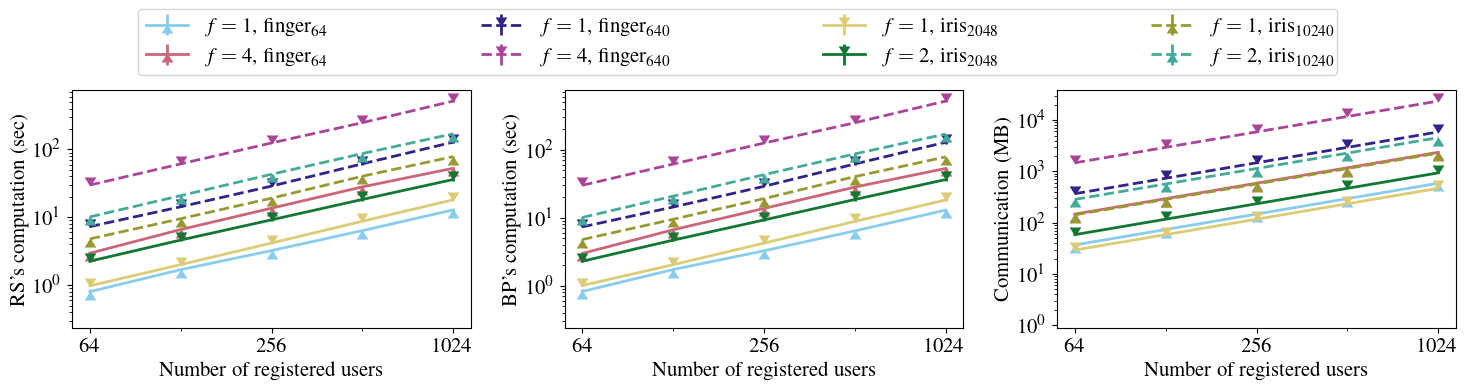

In [12]:
config = {
    (1, 64) : {
        'color': COLOR_PALETTE[0],
        'marker' :  6,
        'linestyle' : 'solid'
    },
    (4, 64) : {
        'color': COLOR_PALETTE[1],
        'marker' :  6,
        'linestyle' : 'solid'
    },
    (1, 640) : {
        'color': COLOR_PALETTE[4],
        'marker' :  7,
        'linestyle' : 'dashed'
    },
    (4, 640) : {
        'color': COLOR_PALETTE[5],
        'marker' :  7,
        'linestyle' : 'dashed'
    },

    (1, 2048) : {
        'color': COLOR_PALETTE[2],
        'marker' :  PLT_MARKER[2],
        'linestyle' : 'solid'
    },
    (2, 2048) : {
        'color': COLOR_PALETTE[3],
        'marker' :  PLT_MARKER[3],
        'linestyle' : 'solid'
    },
    (1, 10240) : {
        'color': COLOR_PALETTE[7],
        'marker' :  6,
        'linestyle' : 'dashed'
    },
    (2, 10240) : {
        'color': COLOR_PALETTE[6],
        'marker' :  6,
        'linestyle' : 'dashed'
    },
}
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
df = full_data.query('approach=="smc" & users >= 64 & users <= 1024 ')
plot_evaluation(axes, df, config, ['smc'])

axes[0].legend(
    bbox_to_anchor=(0.1, 0.82, 0.8, 0), 
    loc='lower left',
    ncol=4, 
    mode="expand", 
    borderaxespad=0., 
    bbox_transform=fig.transFigure,
)


major_ticks = [64, 256, 1024]
minor_ticks = [2*x for x in major_ticks[:-1]]
for i in range(3):
    axes[i].set_xticks(major_ticks, major_ticks)
    axes[i].xaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    axes[i].xaxis.set_minor_formatter(plt.NullFormatter())
    axes[i].set_xlim((56, 1170)) # fix the large empty space in plots

plt.savefig(fig_dir+"smc_long_eval.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show() 

# Comparison with related work
In this section we compare the cost of Janus with related work such as Huang et al. and HERS.

## Huang et al.
We read and process the measurements from Huang et al.

In [13]:
huang = pd.read_csv(f'{data_dir}huang.csv')
huang['task'] = huang['task'].str.strip()
huang['time'] /= 1000

huang = huang.query("N > 4")
huang = huang.groupby(['N', 'M', 'sec', 'task']).mean().reset_index()

offline_phase = ["Yao's Circuit preparation", "OEDPVar preparation", "OT preparation"]
offline = huang.query("task==@offline_phase").groupby(['N', 'M', 'sec', ]).sum()
offline['task'] = 'offline'
offline

onine_phase = ["OEDPVar protocol execution", "reseting circuit wires", "sending mask", "sending labels for selfs inputs", "sending labels for peers inputs", "circuit garbling", ]
online = huang.query("task==@onine_phase").groupby(['N', 'M', 'sec', ]).sum()
online['task'] = 'online'

huang = pd.concat([offline, online]).reset_index()
huang['transfer'] = huang['trans_out'] +huang['trans_in']

We compare the cost of running Hyb-Janus vs Huang et al. This plot corresponds to the Fig 6 in the paper.

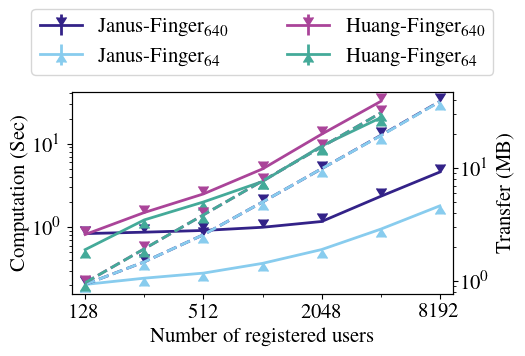

In [14]:
config = {
    640: {
        'color': COLOR_PALETTE[4],
        'marker' :  7,
    },
    64 : {
        'color': COLOR_PALETTE[0],
        'marker' :  6,
    },
}
style = {
    'comp':'solid',
    'transfer':'dashed',
}

fig, ax = plt.subplots(figsize=(5.5, 3.5))
twin = ax.twinx()
prepare_plot_axis(ax)
prepare_plot_axis(twin)

ax.set_ylabel('Computation (Sec)')
twin.set_ylabel('Transfer (MB)')

# Plot the cost of Hyb-Janus
janus_df = full_data.query('bio=="finger" & approach=="he" & fuse==1 &users>64 & users <= 8192 ').copy()
janus_df['comp'] = janus_df['rs_comp'] + janus_df['bp_comp']
for ts in config.keys():
    l_data = janus_df.query(f"template_size=={ts}")
    l_data = l_data[['users', 'comp', 'transfer']].groupby('users').agg(['mean', 'sem']).reset_index()
    x , y, yerr = l_data["users"], l_data[( 'comp', 'mean')], l_data[( 'comp', 'sem')]
    label = f"Janus-Finger$_{{{ts}}}$"
    ax.errorbar(x, y, yerr,  
                linestyle='solid',
                linewidth = 2,
                markersize = 7.5,
                label=label,
                **config[ts]
    )
    x , y, yerr = l_data["users"], l_data[( 'transfer', 'mean')], l_data[( 'transfer', 'sem')]
    label = f"__$"
    twin.errorbar(x, y, yerr,  
                linestyle='dashed',
                linewidth = 2,
                markersize = 7.5,
                label=label,
                **config[ts]
    )

    
# Plot the cost of Huang et al.
config = {
    640: {
        'color': COLOR_PALETTE[5],
        'marker' :  7,
    },
    64 : {
        'color': COLOR_PALETTE[6],
        'marker' :  6,
    },
}
for ts  in config.keys():
    l_data = huang.query(f"M=={ts} & task=='online' & N > 64")
    x , y, yerr = l_data["N"], l_data['time'], 0
    label = f"Huang-Finger$_{{{ts}}}$"
    ax.errorbar(x, y, yerr,  
                linestyle='solid',
                linewidth = 2,
                markersize = 7.5,
                label=label,
                **config[ts]
    )
    x , y, yerr = l_data["N"], l_data['transfer']/1024, 0
    label = f"__$"
    twin.errorbar(x, y, yerr,  
                linestyle='dashed',
                linewidth = 2,
                markersize = 7.5,
                label=label,
                **config[ts]
    )

ax.legend(
    bbox_to_anchor=(0.08, 0.84, 0.84, 0), 
    loc='lower left',
    ncol=2, 
    mode="expand", 
    borderaxespad=0., 
    bbox_transform=fig.transFigure,
)
plt.tight_layout()
plt.savefig(fig_dir+"huang_eval.pdf", bbox_inches='tight', pad_inches=0.01)


## HERS
This approach perform matches in batches of 4096 fingers which leads to a constant cost for scenatios with $<= 4096$ users.
The cost increases linearly afterwards. We measured the cost of execution with $N=4096$ users and hardcoded it.

In [15]:
finger_he = pd.read_csv(f'{data_dir}finger_hyb_dist.csv')
finger_he['comp'] = finger_he['rs_comp'] + finger_he['bp_comp']
finger_he['comp'] /= 1000
finger_he['transfer'] /= (1024*1024)

users = [128, 256, 512, 1024, 2048, 4096, 8192]
ts = [64]*len(users)+ [640]*len(users)
time = [0.375]*len(users) + [4.100]*len(users)
time[len(users)-1] *= 2
time[-1] *= 2
ctx_cost = 131697
transfer=[ctx_cost*(m+1) for m in ts]
transfer[len(users)-1] += ctx_cost
transfer[-1]+= ctx_cost
hers = pd.DataFrame({'users': users*2, 'M': ts, 'time':time, 'transfer': transfer})
hers['transfer'] /= (1024.0*1024)

We plot the cost of running HERS versus the distance computation component of Hyb-Janus which provides a similar functionality/privacy. This plot corresponds to Fig 7 in the paper 

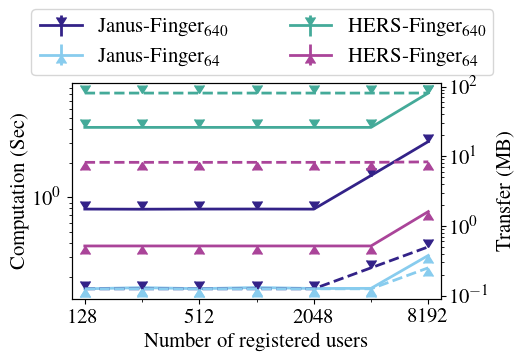

In [16]:
config = {
    640: {
        'color': COLOR_PALETTE[4],
        'marker' :  7,
    },
    64 : {
        'color': COLOR_PALETTE[0],
        'marker' :  6,
    },
}
style = {
    'comp':'solid',
    'transfer':'dashed',
}

fig, ax = plt.subplots(figsize=(5.5, 3.6))
twin = ax.twinx()
prepare_plot_axis(ax)
prepare_plot_axis(twin)

ax.set_ylabel('Computation (Sec)')
twin.set_ylabel('Transfer (MB)')

# plot janus lines
janus_df = finger_he.query('users>64 & users <= 8192 ')
for ts  in config.keys():
    l_data = janus_df.query(f"template_size=={ts}")
    l_data = l_data[['users', 'comp', 'transfer']].groupby('users').agg(['mean', 'sem']).reset_index()
    x , y, yerr = l_data["users"], l_data[( 'comp', 'mean')], l_data[( 'comp', 'sem')]
    label = f"Janus-Finger$_{{{ts}}}$"
    ax.errorbar(x, y, yerr,  
                linestyle='solid',
                linewidth = 2,
                markersize = 7.5,
                label=label,
                **config[ts]
    )
    x , y, yerr = l_data["users"], l_data[( 'transfer', 'mean')], l_data[( 'transfer', 'sem')]
    label = f"__$"
    twin.errorbar(x, y, yerr,  
                linestyle='dashed',
                linewidth = 2,
                markersize = 7.5,
                label=label,
                **config[ts]
    )

    
config = {
    640: {
        'color': COLOR_PALETTE[6],
        'marker' :  7,
    },
    64 : {
        'color': COLOR_PALETTE[5],
        'marker' :  6,
    },
}
# plot hers lines
for ts  in config.keys():
    l_data = hers.query(f"M=={ts}")
    x , y, yerr = l_data["users"], l_data['time'], 0
    label = f"HERS-Finger$_{{{ts}}}$"
    ax.errorbar(x, y, yerr,  
                linestyle='solid',
                linewidth = 2,
                markersize = 7.5,
                label=label,
                **config[ts]
    )
    x , y, yerr = l_data["users"], l_data['transfer'], 0
    label = f"__$"
    twin.errorbar(x, y, yerr,  
                linestyle='dashed',
                linewidth = 2,
                markersize = 7.5,
                label=label,
                **config[ts]
    )

ax.legend(
    bbox_to_anchor=(0.08, 0.83, 0.84, 0), 
    loc='lower left',
    ncol=2, 
    mode="expand", 
    borderaxespad=0., 
    
    bbox_transform=fig.transFigure,
)
plt.tight_layout()
plt.savefig(fig_dir+"hers_eval.pdf", bbox_inches='tight', pad_inches=0.01)
